#

# Working with data from official providers: a brief tour of pandaSDMX

This notebook contains the code used in the related blog post. See the blog post for more detailed explanations.

This example connects to the Eurostat SDMX client and obtains data on the share of individuals using the Internet for online banking in some European countries.

In [72]:
import pandas as pd
import pandasdmx as sdmx

import matplotlib.pyplot as plt

## Select data source

The string ID for Eurostat is "ESTAT".

In [168]:
estat = sdmx.Request('ESTAT')

You can open Eurostat's API documentation in the browser with the following line.

In [169]:
estat.view_doc()

## Data flows

We get all dataflows from the estat client.

In [170]:
flow_msg = estat.dataflow()

This gives us a StructureMessage (in contrast to DataMessage we will see later).

In [171]:
flow_msg

<pandasdmx.StructureMessage>
  <Header>
    id: 'DF1702479017'
    prepared: '2023-12-13T15:50:17.905000+01:00'
    sender: <Agency ESTAT>
    source: 
    test: False
  response: <Response [200]>
  DataflowDefinition (7537): MAR_MP_AM_CFT MAR_MP_AM_CFTT MAR_MT_AM_CSV...
  DataStructureDefinition (7143): MAR_MP_AM_CFT MAR_MP_AM_CFTT MAR_MT_A...

In [172]:
# picking a dataflow from the IDs we already see in the StructureMessage
flow_msg.dataflow.MAR_PA_QM_PT

<DataflowDefinition ESTAT:MAR_PA_QM_PT(1.0): Passengers (excluding cruise passengers) transported from/to the main ports - Portugal - quarterly data>

In [173]:
flow_msg.response.url

'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/ESTAT'

In [174]:
flow_msg.response.headers

{'Date': 'Wed, 13 Dec 2023 15:11:32 GMT', 'Transfer-Encoding': 'chunked', 'Content-Type': 'application/vnd.sdmx.structure+xml;version=2.1', 'Content-Disposition': 'attachment; filename="ALL_DATAFLOWS.xml"', 'Server-Timing': 'dtRpid;desc="-583812957", dtSInfo;desc="0"', 'X-OneAgent-JS-Injection': 'true', 'Connection': 'keep-alive', 'Set-Cookie': 'dtCookie=v_4_srv_35_sn_6E26E6BF4AF8B18398944F0A9E02ABBC_perc_100000_ol_0_mul_1_app-3Ae63eebabdf39f376_1; Path=/; Domain=.europa.eu/eurostat/api/dissemination'}

## Finding a dataflow

In [175]:
# more than 7000 dataflows available
len(flow_msg.dataflow)

7537

We can convert metadata into a pandas object for easier inspection.

In [176]:
dataflows = sdmx.to_pandas(flow_msg.dataflow)

In [177]:
type(dataflows)

pandas.core.series.Series

In [178]:
dataflows.head()

MAR_MP_AM_CFT     Passengers (excluding cruise passengers) trans...
MAR_MP_AM_CFTT    Passengers (excluding cruise passengers) trans...
MAR_MT_AM_CSVI    Country level - number and gross tonnage of ve...
MAR_PA_AA         Passengers embarked and disembarked in all por...
MAR_PA_QM         Passengers (excluding cruise passengers) trans...
dtype: object

Now, we narrow it down to just the dataflows that we are interested in using a pandas str method.

In [179]:
internet_use_flows = dataflows[dataflows.str.contains('Individuals using the internet', case=False)]

We narrow it down to ten dataflows.

In [181]:
print(internet_use_flows)

TIN00094    Individuals using the internet for sending/rec...
TIN00095    Individuals using the internet for finding inf...
TIN00096    Individuals using the internet for buying good...
TIN00098    Individuals using the internet for selling goo...
TIN00099    Individuals using the internet for internet ba...
TIN00101    Individuals using the internet for seeking hea...
TIN00102    Individuals using the internet for looking for...
TIN00103    Individuals using the internet for doing an on...
TIN00127    Individuals using the internet for participati...
TIN00129    Individuals using the internet for taking part...
dtype: object


We pick the one about 'Individuals using the internet for internet banking'.

In [188]:
internet_use_flows.TIN00099

'Individuals using the internet for internet banking'

## Invesigating the structure of a dataflow

We get this specific dataflow based on the ID we found.

In [189]:
tin_msg = estat.dataflow("TIN00099")

Again a StructureMessage.

In [190]:
tin_msg

<pandasdmx.StructureMessage>
  <Header>
    id: 'DF1702041294'
    prepared: '2023-12-08T13:14:54.798000+00:00'
    sender: <Agency ESTAT>
    source: 
    test: False
  response: <Response [200]>
  Codelist (6): FREQ INDIC_IS UNIT IND_TYPE GEO OBS_FLAG
  ConceptScheme (1): TIN00099
  DataflowDefinition (1): TIN00099
  DataStructureDefinition (1): TIN00099

We get the dataflow from the message.

In [191]:
tin_flow = tin_msg.dataflow.TIN00099

In [194]:
tin_flow

<DataflowDefinition ESTAT:TIN00099(1.0): Individuals using the internet for internet banking>

We get the data structure definition.

In [195]:
dsd = tin_flow.structure

In [196]:
dsd

<DataStructureDefinition ESTAT:TIN00099(34.1): TIN00099 data structure>

The DSD has dimensions, attributes and measures.

1. Dimensions

In [197]:
dsd.dimensions.components

[<Dimension freq>,
 <Dimension indic_is>,
 <Dimension unit>,
 <Dimension ind_type>,
 <Dimension geo>,
 <TimeDimension TIME_PERIOD>]

2. Attributes

In [199]:
# one type of attribute: OBS_FLAG
dsd.attributes.components

[<DataAttribute OBS_FLAG>]

In [200]:
dsd.attributes.components[0].local_representation.enumerated.items

{'b': <Code b: break in time series>,
 'bc': <Code bc: break in time series, confidential>,
 'bcd': <Code bcd: break in time series, confidential, definition differs (see metadata)>,
 'bd': <Code bd: break in time series, definition differs (see metadata)>,
 'bde': <Code bde: break in time series, definition differs (see metadata), estimated>,
 'bdep': <Code bdep: break in time series, definition differs (see metadata), estimated, provisional>,
 'bdf': <Code bdf: break in time series, definition differs (see metadata), forecast>,
 'bdn': <Code bdn: break in time series, definition differs (see metadata), not significant>,
 'bdp': <Code bdp: break in time series, definition differs (see metadata), provisional>,
 'bdps': <Code bdps: break in time series, definition differs (see metadata), provisional, Eurostat estimate>,
 'bds': <Code bds: break in time series, definition differs (see metadata), Eurostat estimate>,
 'bdu': <Code bdu: break in time series, definition differs (see metadata

3. Measures

In [201]:
dsd.measures.components

[<PrimaryMeasure OBS_VALUE>]

### Codelists

In [204]:
cl_freq = dsd.dimensions.get('freq').local_representation.enumerated

In [205]:
cl_freq

<Codelist ESTAT:FREQ(3.2) (11 items): Time frequency>

In [206]:
cl_freq_pd = sdmx.to_pandas(cl_freq)

In [207]:
print(cl_freq_pd)

                         name parent
FREQ                                
P                Pluri-annual   FREQ
A                      Annual   FREQ
S     Half-yearly, semesterly   FREQ
Q                   Quarterly   FREQ
M                     Monthly   FREQ
W                      Weekly   FREQ
B       Daily - business week   FREQ
D                       Daily   FREQ
H                      Hourly   FREQ
I      Irregular / A-periodic   FREQ
NAP            Not applicable   FREQ


In [208]:
cl_ind = dsd.dimensions.get('ind_type').local_representation.enumerated
cl_ind_df = sdmx.to_pandas(cl_ind)
cl_ind_df

,name,parent
IND_TYPE,,
TOTAL,Total,IND_TYPE
IND_TOTAL,All Individuals,IND_TYPE
Y0_15,"Individuals, 15 years old or less",IND_TYPE
Y15_29,"Individuals, 15 to 29 years old",IND_TYPE
Y16_19,"Individuals, 16 to 19 years old",IND_TYPE
...,...,...
Y55_74_DIS_NONE,Individuals aged 55 to 74 with disability (act...,IND_TYPE
SPHS_LTD,"Self-perceived health status: limited, but not...",IND_TYPE
SPHS_LTD_SEV,Self-perceived health status: limited or sever...,IND_TYPE


In [210]:
cl_geo = dsd.dimensions.get('geo').local_representation.enumerated
cl_geo_pd = sdmx.to_pandas(cl_geo)
print(cl_geo_pd)

                                                             name parent
GEO                                                                     
EUR                                                        Europe    GEO
EU              European Union (EU6-1958, EU9-1973, EU10-1981,...    GEO
EU_V            European Union (aggregate changing according t...    GEO
EU27_2020_EFTA  European Union - 27 countries (from 2020) and ...    GEO
EU27_2020_IS_K  European Union - 27 countries (from 2020) and ...    GEO
...                                                           ...    ...
NAL                                                 Not allocated    GEO
NAP                                                Not applicable    GEO
NRP                                                   No response    GEO
NSP                                                 Not specified    GEO
UNK                                                       Unknown    GEO

[4041 rows x 2 columns]


Another way to access codelists.

In [211]:
tin_msg.codelist

{'FREQ': <Codelist ESTAT:FREQ(3.2) (11 items): Time frequency>,
 'INDIC_IS': <Codelist ESTAT:INDIC_IS(13.1) (2123 items): Information society indicator>,
 'UNIT': <Codelist ESTAT:UNIT(21.1) (709 items): Unit of measure>,
 'IND_TYPE': <Codelist ESTAT:IND_TYPE(5.1) (186 items): Individual type>,
 'GEO': <Codelist ESTAT:GEO(14.4) (4041 items): Geopolitical entity (reporting)>,
 'OBS_FLAG': <Codelist ESTAT:OBS_FLAG(1.33) (46 items): Observation status (Flag)>}

Another way to access the data structure.

In [212]:
metadata = estat.datastructure('TIN00099')

In [213]:
metadata

<pandasdmx.StructureMessage>
  <Header>
    id: 'DSD1702041361'
    prepared: '2023-12-08T13:16:01.698000+00:00'
    sender: <Agency ESTAT>
    source: 
    test: False
  response: <Response [200]>
  Codelist (6): FREQ INDIC_IS UNIT IND_TYPE GEO OBS_FLAG
  ConceptScheme (1): TIN00099
  DataStructureDefinition (1): TIN00099

In [278]:
metadata.codelist

{'FREQ': <Codelist ESTAT:FREQ(3.2) (11 items): Time frequency>,
 'INDIC_IS': <Codelist ESTAT:INDIC_IS(13.1) (2123 items): Information society indicator>,
 'UNIT': <Codelist ESTAT:UNIT(21.1) (709 items): Unit of measure>,
 'IND_TYPE': <Codelist ESTAT:IND_TYPE(5.1) (186 items): Individual type>,
 'GEO': <Codelist ESTAT:GEO(14.4) (4041 items): Geopolitical entity (reporting)>,
 'OBS_FLAG': <Codelist ESTAT:OBS_FLAG(1.33) (46 items): Observation status (Flag)>}

## Query the data

From above analysis of the structure, we can decide how to filter a subset of the data.

In [214]:
key = dict(freq="A", indic_is="I_IUBK", unit="PC_IND", geo="DE+FR+EE+PL+RO")
params = dict(startPeriod='2011', endPeriod='2022')

In [215]:
data_msg = estat.data('TIN00099', key=key, params=params)

2023-12-13 16:41:00,748 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


In [216]:
data_msg.response.headers['content-type']

'application/vnd.sdmx.genericdata+xml;version=2.1'

In [217]:
data_msg.response.url

'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/TIN00099/A.I_IUBK.PC_IND..DE+EE+FR+PL+RO?startPeriod=2011&endPeriod=2022'

In [218]:
data_msg

<pandasdmx.DataMessage>
  <Header>
    extracted: '2023-12-13T10:15:14.435000+00:00'
    id: '21212EEF50234E8BBDF01C8E1CF02DEC'
    prepared: '2023-12-13T10:15:14.435000+00:00'
    sender: <Agency ESTAT>
    source: 
    test: False
  response: <Response [200]>
  DataSet (1)
  dataflow: <DataflowDefinition (missing id)>
  observation_dimension: <TimeDimension TIME_PERIOD>

We exctract a list of GenericDataSets from the message. In this case there is one data set in that list.

In [219]:
data_msg.data

[GenericDataSet(annotations=[], action=None, attrib={}, valid_from=None, described_by=None, structured_by=<DataStructureDefinition ESTAT:TIN00099(34.1): TIN00099 data structure>, obs=[Observation(attached_attribute={}, series_key=<SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=DE>, dimension=<Key: TIME_PERIOD=2011>, value='45.25', value_for=None, group_keys=set()), Observation(attached_attribute={}, series_key=<SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=DE>, dimension=<Key: TIME_PERIOD=2012>, value='45.07', value_for=None, group_keys=set()), Observation(attached_attribute={}, series_key=<SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=DE>, dimension=<Key: TIME_PERIOD=2013>, value='47.12', value_for=None, group_keys=set()), Observation(attached_attribute={}, series_key=<SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=DE>, dimension=<Key: TIME_PERIOD=2014>, value='48.76', value_for=N

In [220]:
data = data_msg.data[0]

The data consists of series and observations.

There are five series (one for each country).

In [221]:
len(data.series)

5

The series have keys. E.g. the first one for the series with the data for Germany.

In [223]:
data.series.keys()

dict_keys([<SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=DE>, <SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=EE>, <SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=FR>, <SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=PL>, <SeriesKey: freq=A, indic_is=I_IUBK, unit=PC_IND, ind_type=IND_TOTAL, geo=RO>])

Observations correspond to cells in a data table. We have 12(years) * 5(countries) - 1 (missing data) = 59 observations.

In [224]:
len(data.obs)

59

We convert the data into a pandas object.

In [225]:
data_df = data_msg.to_pandas()

It's a pandas series.

In [226]:
type(data_df)

pandas.core.series.Series

... with a multi index.

In [228]:
data_df.index

MultiIndex([('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2011'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2012'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2013'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2014'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2015'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2016'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2017'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2018'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2019'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2020'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2021'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'DE', '2022'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'EE', '2011'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'EE', '2012'),
            ('A', 'I_IUBK', 'PC_IND', 'IND_TOTAL', 'EE', '2013'),
          

A more convenient way to arrange the data is this:

In [142]:
data_df2 = sdmx.to_pandas(data, datetime={'dim': 'TIME_PERIOD', 'freq': 'freq', 'axis': 1})

This time we get a dataframe.

In [229]:
type(data_df2)

pandas.core.frame.DataFrame

The datetime argument transforms the years into a PeriodIndex in the columns (axis 1).

In [230]:
data_df2.columns

PeriodIndex(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
             '2019', '2020', '2021', '2022'],
            dtype='period[A-DEC]', name='TIME_PERIOD')

In [231]:
data_df2

TIME_PERIOD                     2011   2012   2013   2014   2015   2016  \
indic_is unit   ind_type  geo                                             
I_IUBK   PC_IND IND_TOTAL DE   45.25  45.07  47.12  48.76  50.98  52.97   
                          EE   67.59  68.06  72.22  76.56  80.67  78.59   
                          FR   50.90  54.04  57.56  57.60  58.28  59.36   
                          PL   27.46  31.96  32.01  32.59  31.20  39.11   
                          RO    3.51   3.45   4.30   4.16   5.34   5.06   

TIME_PERIOD                     2017   2018   2019   2020   2021   2022  
indic_is unit   ind_type  geo                                            
I_IUBK   PC_IND IND_TOTAL DE   55.56  58.84  61.10  64.91  50.35  48.58  
                          EE   79.23  80.36  80.72  79.84  81.51  83.36  
                          FR   62.01  63.48  65.55    NaN  71.60  67.86  
                          PL   39.77  44.01  47.27  49.49  52.24  55.55  
                          RO    6.83   6.87   8.36  11.65  15.49  19.19

A final clean-up to have a simple index with only the countries.

In [232]:
data_final = data_df2.xs(key=("I_IUBK", "PC_IND", "IND_TOTAL"), level=("indic_is", "unit", "ind_type"))

In [233]:
data_final

TIME_PERIOD,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
geo,,,,,,,,,,,,
DE,45.25,45.07,47.12,48.76,50.98,52.97,55.56,58.84,61.10,64.91,50.35,48.58
EE,67.59,68.06,72.22,76.56,80.67,78.59,79.23,80.36,80.72,79.84,81.51,83.36
FR,50.90,54.04,57.56,57.60,58.28,59.36,62.01,63.48,65.55,NaN,71.60,67.86
PL,27.46,31.96,32.01,32.59,31.20,39.11,39.77,44.01,47.27,49.49,52.24,55.55
RO,3.51,3.45,4.30,4.16,5.34,5.06,6.83,6.87,8.36,11.65,15.49,19.19


The missing data point we have already noticed is FR-2020.

## Visualise the data

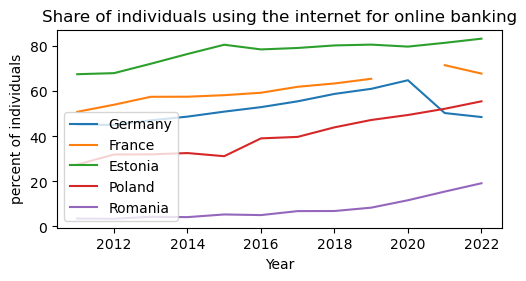

In [244]:
x = [period.year for period in data_final.columns.values]
plt.figure(figsize=(5, 2.7), layout='constrained')
plt.plot(x, data_final.loc['DE', :].values, label='Germany')
plt.plot(x, data_final.loc['FR', :].values, label='France')
plt.plot(x, data_final.loc['EE', :].values, label='Estonia')
plt.plot(x, data_final.loc['PL', :].values, label='Poland')
plt.plot(x, data_final.loc['RO', :].values, label='Romania')
plt.xlabel('Year')
plt.ylabel('percent of individuals')
plt.title("Share of individuals using the internet for online banking")
plt.legend(loc="lower left")
# plt.savefig("eurostat_sdmx_iubk.png")
plt.show()

## Other issues mentioned in the post

Internationalisation: We can change the language used.

Currently, we use English.

In [245]:
estat.default_locale

'en'

We can switch to French.

In [246]:
estat.default_locale = "fr"

Then we can get all names for dataflows, dimensions, codelists, etc. in French like in the following example.

In [247]:
estat= sdmx.Request("ESTAT")

In [248]:
tin_msg = estat.dataflow("TIN00099")

In [249]:
geo_df = sdmx.to_pandas(tin_msg.codelist.GEO.items)

In [250]:
geo_df

EUR                                                          Europe
EU                Union européenne (UE6-1958, UE9-1973, UE10-198...
EU_V              Union européenne (agrégat variable en fonction...
EU27_2020_EFTA    Union européenne - 27 pays (à partir de 2020) ...
EU27_2020_IS_K    Union européenne - 27 pays (à partir de 2020) ...
                                        ...                        
NAL                                                      Non alloué
NAP                                                  Non applicable
NRP                                                    Sans réponse
NSP                                                    Non spécifié
UNK                                                      Inconnu(s)
Length: 4041, dtype: object